# Building the ML dataframe

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

In [3]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 80

In [4]:
# Directory where data files will be downloaded
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Load in latest wind turbine data
- Note: Only 9 turbines decommissioned before 2019!

In [375]:
# Read in latest turbine data
# Now only 30,642 after removing 3 turbines outside bounding box
df_turbines = pd.read_pickle(data_push_path / 'df_turbines_knn_blades_haversine_elevation_utc.pkl')
df_turbines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30642 entries, 0 to 30641
Data columns (total 30 columns):
 #   Column                                            Non-Null Count  Dtype              
---  ------                                            --------------  -----              
 0   EinheitMastrNummer                                30642 non-null  object             
 1   DatumLetzteAktualisierung                         30642 non-null  datetime64[ns, UTC]
 2   Bundesland                                        30642 non-null  object             
 3   Postleitzahl                                      30642 non-null  int64              
 4   Ort                                               30642 non-null  object             
 5   Laengengrad                                       30642 non-null  float64            
 6   Breitengrad                                       30642 non-null  float64            
 7   Registrierungsdatum                               30642 non-null  d

In [376]:
# List of datetime column names for convenient indexing later
turbine_date_columns = [
    'DatumLetzteAktualisierung',
    'Registrierungsdatum',
    'Inbetriebnahmedatum',
    'DatumEndgueltigeStilllegung',
    'DatumBeginnVoruebergehendeStilllegung',
    'DatumWiederaufnahmeBetrieb'
]

In [371]:
# # Cast all tz naive datetime64 columns to UTC tz aware
# df_turbines[turbine_date_columns] = df_turbines[turbine_date_columns].apply(lambda series: series.dt.tz_localize('UTC'), axis=0)

# # save to pickle
# df_turbines.to_pickle(data_push_path / 'df_turbines_knn_blades_haversine_elevation_utc.pkl')

-----

#### Load in SMARD energy generated data

In [680]:
# Get all SMARD CSV files, load into dataframes, and concat them

def load_SMARD_generated_data():
    """
    Look for CSV files in the SMARD directory
    """
    list_of_dataframes = []
    for filepath in data_path.joinpath('SMARD').iterdir():
        if filepath.name.startswith('Realisierte_Erzeugung'):
            list_of_dataframes.append(pd.read_csv(filepath, sep=';'))
            
    # Check that num of rows is what I expect after concatenating dfs
    num_of_rows = 0
    for df in list_of_dataframes:
        num_of_rows += len(df)
    
    # concat dataframes
    df = pd.concat(list_of_dataframes)
    print(f'Number of rows match up: {num_of_rows == len(df)}')
    
    # Select columns to keep
    # Note: I'm using the interval start time to create the timestamps
    # ERA5 surface parameters are instantaneous so can't perfectly align anyway
    df = df[[
        'Datum',
        'Anfang',
        # 'Ende',
        'Wind Onshore [MWh] Berechnete Auflösungen'
    ]]
    
    # rename columns
    df.rename(columns={
        'Datum': 'date',
        'Anfang': 'interval_start_time', 
        # 'Ende': 'interval_end_time',
        'Wind Onshore [MWh] Berechnete Auflösungen': 'onshore_generated_mwh'
    }, inplace=True)
    
    # Handle dates and times to create unified datetime64 timestamps
    df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
    df['start_time_delta'] = pd.to_timedelta(df['interval_start_time'] + ':00')
    df['datetime_cet'] = df['date'] + df['start_time_delta']
    # Add CET timezone info and infer change from CET->CEST->CET, etc
    df['datetime_cet'] = df['datetime_cet'].dt.tz_localize(tz='CET', ambiguous='infer')
    
    # Drop un-needed columns
    df = df.drop(columns=['date', 'start_time_delta', 'interval_start_time'])
    # Re-arrange columns
    df = df[['datetime_cet', 'onshore_generated_mwh']]
    
    # Convert European thousands and decimal seperators in values to (US/UK) decimal full stop format
    translation_table = str.maketrans({'.': None, ',': '.'})
    df['onshore_generated_mwh'] = df['onshore_generated_mwh'].str.translate(translation_table).astype(float)
    
    # Sort rows by datetime_cet
    df.sort_values('datetime_cet', inplace=True)
    # Reset index
    df.reset_index(drop=True, inplace=True)
    
    return df.copy()

In [681]:
# Load SMARD data
df_smard_generated = load_SMARD_generated_data()
df_smard_generated.info()

Number of rows match up: True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49655 entries, 0 to 49654
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   datetime_cet           49655 non-null  datetime64[ns, CET]
 1   onshore_generated_mwh  49655 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 776.0 KB


In [682]:
# df_smard[df_smard['datetime'] < pd.Timestamp('2022-10-30')]

In [683]:
df_smard_generated.head(3)

,datetime_cet,onshore_generated_mwh
0,2018-01-01 00:00:00+01:00,28503.50
1,2018-01-01 01:00:00+01:00,29638.00
2,2018-01-01 02:00:00+01:00,30173.75


-----

#### Load in SMARD day-ahead prices
- Wholesale prices: https://www.smard.de/page/en/wiki-article/5884/5976
- This is the day-ahead price!
    - "Weighted wholesale electricity price (day-ahead price on the exchange) for each hour [€/MWh] determined on the day-ahead auction that took place ones on the previous day - data is delivered no later than 2 hours after trading closes. Source: ENTSO-E"
- Data only goes back to 2018-10-01 (October 1, 2018)

In [716]:
# Get all SMARD CSV files, load into dataframes, and concat them

def load_SMARD_market_price_data():
    """
    Look for CSV files in the SMARD directory
    """
    list_of_dataframes = []
    for filepath in data_path.joinpath('SMARD').iterdir():
        if filepath.name.startswith('Gro_handelspreise'):
            list_of_dataframes.append(pd.read_csv(filepath, sep=';', na_values='-'))
            
    # Check that num of rows is what I expect after concatenating dfs
    num_of_rows = 0
    for df in list_of_dataframes:
        num_of_rows += len(df)
    
    # concat dataframes
    df = pd.concat(list_of_dataframes)
    print(f'Number of rows match up: {num_of_rows == len(df)}')
    
    # Select columns to keep
    # Note: I'm using the interval start time to create the timestamps
    # ERA5 surface parameters are instantaneous so can't perfectly align anyway
    df = df[[
        'Datum',
        'Anfang',
        # 'Ende',
        'Deutschland/Luxemburg [€/MWh] Originalauflösungen'
    ]]
    
    # rename columns
    df.rename(columns={
        'Datum': 'date',
        'Anfang': 'interval_start_time', 
        # 'Ende': 'interval_end_time',
        'Deutschland/Luxemburg [€/MWh] Originalauflösungen': 'day_ahead_price_eur_mwh'
    }, inplace=True)
    
    # Handle dates and times to create unified datetime64 timestamps
    df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
    df['start_time_delta'] = pd.to_timedelta(df['interval_start_time'] + ':00')
    df['datetime_cet'] = df['date'] + df['start_time_delta']
    # Add CET timezone info and infer change from CET->CEST->CET, etc
    df['datetime_cet'] = df['datetime_cet'].dt.tz_localize(tz='CET', ambiguous='infer')
    
    # Drop un-needed columns
    df = df.drop(columns=['date', 'start_time_delta', 'interval_start_time'])
    # Re-arrange columns
    df = df[['datetime_cet', 'day_ahead_price_eur_mwh']]
    
    # Convert European thousands and decimal seperators in values to (US/UK) decimal full stop format
    translation_table = str.maketrans({'.': None, ',': '.'})
    df['day_ahead_price_eur_mwh'] = df['day_ahead_price_eur_mwh'].str.translate(translation_table).astype(float)
    
    # Sort rows by datetime_cet
    df.sort_values('datetime_cet', inplace=True)
    # Reset index
    df.reset_index(drop=True, inplace=True)
    
    return df.copy()

In [717]:
df_smard_market_price = load_SMARD_market_price_data()

Number of rows match up: True


In [718]:
# df_smard_market_price = pd.read_csv(data_path.joinpath('SMARD') / 'Gro_handelspreise_202201010000_202212312359_Stunde.csv', sep=';')

In [719]:
df_smard_market_price.iloc[6550:].head(20)

,datetime_cet,day_ahead_price_eur_mwh
6550,2018-09-30 23:00:00+02:00,NaN
6551,2018-10-01 00:00:00+02:00,59.53
6552,2018-10-01 01:00:00+02:00,56.10
6553,2018-10-01 02:00:00+02:00,51.41
6554,2018-10-01 03:00:00+02:00,47.38
6555,2018-10-01 04:00:00+02:00,47.59
6556,2018-10-01 05:00:00+02:00,51.61
6557,2018-10-01 06:00:00+02:00,69.13
6558,2018-10-01 07:00:00+02:00,77.32
6559,2018-10-01 08:00:00+02:00,84.97


In [721]:
df_smard_market_price.isna().sum()

datetime_cet                  0
day_ahead_price_eur_mwh    6551
dtype: int64

In [720]:
df_smard_market_price['day_ahead_price_eur_mwh'].describe()

count    43848.000000
mean        98.728242
std        106.185053
min       -500.000000
25%         35.500000
50%         56.065000
75%        121.902500
max        871.000000
Name: day_ahead_price_eur_mwh, dtype: float64

-----

#### Load in SMARD installed capacity data

In [722]:
def load_SMARD_installed_capacity_data():
    """
    Look for CSV files in the SMARD directory
    """
    list_of_dataframes = []
    for filepath in data_path.joinpath('SMARD').iterdir():
        if filepath.name.startswith('Installierte_Erzeugungsleistung'):
            list_of_dataframes.append(pd.read_csv(filepath, sep=';'))
            
    # Check that num of rows is what I expect after concatenating dfs
    num_of_rows = 0
    for df in list_of_dataframes:
        num_of_rows += len(df)
    
    # concat dataframes
    df = pd.concat(list_of_dataframes)
    print(f'Number of rows match up: {num_of_rows == len(df)}')
    
    return df.copy()

In [723]:
df_smard_installed_capacity = load_SMARD_installed_capacity_data()

Number of rows match up: True


In [724]:
df_smard_installed_capacity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41639 entries, 0 to 5830
Data columns (total 15 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Datum                                                41639 non-null  object 
 1   Anfang                                               41639 non-null  object 
 2   Ende                                                 41639 non-null  object 
 3   Biomasse [MW] Berechnete Auflösungen                 41639 non-null  float64
 4   Wasserkraft [MW] Berechnete Auflösungen              41639 non-null  float64
 5   Wind Offshore [MW] Berechnete Auflösungen            41639 non-null  float64
 6   Wind Onshore [MW] Berechnete Auflösungen             41639 non-null  float64
 7   Photovoltaik [MW] Berechnete Auflösungen             41639 non-null  float64
 8   Sonstige Erneuerbare [MW] Berechnete Auflösungen     41639 non-null  int

In [725]:
df_smard_installed_capacity

,Datum,Anfang,Ende,Biomasse [MW] Berechnete Auflösungen,Wasserkraft [MW] Berechnete Auflösungen,Wind Offshore [MW] Berechnete Auflösungen,Wind Onshore [MW] Berechnete Auflösungen,Photovoltaik [MW] Berechnete Auflösungen,Sonstige Erneuerbare [MW] Berechnete Auflösungen,Kernenergie [MW] Berechnete Auflösungen,Braunkohle [MW] Berechnete Auflösungen,Steinkohle [MW] Berechnete Auflösungen,Erdgas [MW] Berechnete Auflösungen,Pumpspeicher [MW] Berechnete Auflösungen,Sonstige Konventionelle [MW] Berechnete Auflösungen
0,01.01.2021,00:00,01:00,8.400,5.112,7.774,54.499,53.302,464,8.114,20.487,23.499,31.942,9.422,7.463
1,01.01.2021,01:00,02:00,8.400,5.112,7.774,54.499,53.302,464,8.114,20.487,23.499,31.942,9.422,7.463
2,01.01.2021,02:00,03:00,8.400,5.112,7.774,54.499,53.302,464,8.114,20.487,23.499,31.942,9.422,7.463
3,01.01.2021,03:00,04:00,8.400,5.112,7.774,54.499,53.302,464,8.114,20.487,23.499,31.942,9.422,7.463
4,01.01.2021,04:00,05:00,8.400,5.112,7.774,54.499,53.302,464,8.114,20.487,23.499,31.942,9.422,7.463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5826,31.08.2023,19:00,20:00,8.467,5.148,8.129,57.590,63.066,440,4.056,17.692,18.127,31.808,10.028,8.958
5827,31.08.2023,20:00,21:00,8.467,5.148,8.129,57.590,63.066,440,4.056,17.692,18.127,31.808,10.028,8.958
5828,31.08.2023,21:00,22:00,8.467,5.148,8.129,57.590,63.066,440,4.056,17.692,18.127,31.808,10.028,8.958
5829,31.08.2023,22:00,23:00,8.467,5.148,8.129,57.590,63.066,440,4.056,17.692,18.127,31.808,10.028,8.958


------

#### Load in SMARD day-ahead generation forecast

In [ ]:
def load_SMARD_forecasted_generation_data():
    """
    Look for CSV files in the SMARD directory
    """
    list_of_dataframes = []
    for filepath in data_path.joinpath('SMARD').iterdir():
        if filepath.name.startswith('Prognostizierte_Erzeugung_Day-Ahead'):
            list_of_dataframes.append(pd.read_csv(filepath, sep=';'))
            
    # Check that num of rows is what I expect after concatenating dfs
    num_of_rows = 0
    for df in list_of_dataframes:
        num_of_rows += len(df)
    
    # concat dataframes
    df = pd.concat(list_of_dataframes)
    print(f'Number of rows match up: {num_of_rows == len(df)}')
    
    return df.copy()

In [ ]:
df_smard_market_price = load_SMARD_market_price_data()

-----

## Begin building ML dataframe `df_main`
- Start with one full year: 2022
    - Then bring in another year like 2021 and run through the same transformations and then concat along datetimeindex?
- Good resource on time-related feature engineering: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

In [617]:
# Year 2022
# Make time zone aware UTC?
datetime_index_utc = pd.date_range(start='2022-01-01', end='2022-12-31 23:59:59', freq='H', name='datetime_utc', tz='UTC')

# Make index to dataframe and reset
df_main = datetime_index_utc.to_frame().reset_index(drop=True)

# Extract properties and derive new columns
df_main['hour'] = df_main['datetime_utc'].dt.hour
# 0-6 (Monday-Sunday)
df_main['day_of_week'] = df_main['datetime_utc'].dt.dayofweek
df_main['day_of_month'] = df_main['datetime_utc'].dt.day
df_main['month_number'] = df_main['datetime_utc'].dt.month

# Function to get meteorological season based on month number (1-12)
# Should I just go ahead and encode the discrete numerical value?
def get_meteorological_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    else:
        return 'winter'
    
df_main['meteorological_season'] = df_main['month_number'].apply(get_meteorological_season)

df_main

,datetime_utc,hour,day_of_week,day_of_month,month_number,meteorological_season
0,2022-01-01 00:00:00+00:00,0,5,1,1,winter
1,2022-01-01 01:00:00+00:00,1,5,1,1,winter
2,2022-01-01 02:00:00+00:00,2,5,1,1,winter
3,2022-01-01 03:00:00+00:00,3,5,1,1,winter
4,2022-01-01 04:00:00+00:00,4,5,1,1,winter
...,...,...,...,...,...,...
8755,2022-12-31 19:00:00+00:00,19,5,31,12,winter
8756,2022-12-31 20:00:00+00:00,20,5,31,12,winter
8757,2022-12-31 21:00:00+00:00,21,5,31,12,winter
8758,2022-12-31 22:00:00+00:00,22,5,31,12,winter


----

## Derive new columns `turbines_in_operation` and `total_nominal_capacity_operational_turbines_mwh`

#### Function to check if turbine operational at a given UTC hour timestamp

In [618]:
def is_operational(timestamp_utc, df_turbines):
    """
    Inputs: hourly tz aware utc timestamps, turbine dataframe
    Get a bool series of turbines that are operational at the time of the [hourly] timestamp
    """
    # Turbines that went into operation before the timestamp; returns bool series for bool indexing
    started_operations = df_turbines['Inbetriebnahmedatum'] <= timestamp_utc

    # Turbines already decommissioned before the timestamp; returns bool series for bool indexing
    already_decommissioned = df_turbines['DatumEndgueltigeStilllegung'] <= timestamp_utc

    # Turbines that went into maintenance before timestamp and haven't come back into operation before the timestamp
    # Note: Some turbines go straight from temporary maintenance to decommissioned without ever going back into operation
    still_in_maintenance_or_decommissioned = (df_turbines['DatumBeginnVoruebergehendeStilllegung'] <= timestamp_utc) & \
    ((df_turbines['DatumWiederaufnahmeBetrieb'] > timestamp_utc) | df_turbines['DatumWiederaufnahmeBetrieb'].isna())

    # Number of turbines operational at the timestamp
    # Note the tildas to inverse these bool series
    # This is a bool series with df_turbines index
    turbines_in_operation_bool_series = (started_operations & ~already_decommissioned & ~still_in_maintenance_or_decommissioned)

    return turbines_in_operation_bool_series

##### Derive column for total turbines in operation for every hourly timestamp

In [619]:
df_main['turbines_in_operation'] = df_main['datetime_utc'].apply(lambda timestamp: is_operational(timestamp, df_turbines).sum())

##### Derive column for total nominal capacity for every hourly timestamp

In [625]:
# Note that I divide by 1_000 to convert kilo-watts (kW) to mega-watts (MW)
df_main['total_nominal_capacity_operational_turbines_mwh'] = df_main['datetime_utc'].apply(
    lambda timestamp: df_turbines.loc[:, 'Nettonennleistung'].loc[is_operational(timestamp, df_turbines)].sum() / 1_000)

In [622]:
df_main

,datetime_utc,hour,day_of_week,day_of_month,month_number,meteorological_season,turbines_in_operation
0,2022-01-01 00:00:00+00:00,0,5,1,1,winter,28965
1,2022-01-01 01:00:00+00:00,1,5,1,1,winter,28965
2,2022-01-01 02:00:00+00:00,2,5,1,1,winter,28965
3,2022-01-01 03:00:00+00:00,3,5,1,1,winter,28965
4,2022-01-01 04:00:00+00:00,4,5,1,1,winter,28965
...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00+00:00,19,5,31,12,winter,29262
8756,2022-12-31 20:00:00+00:00,20,5,31,12,winter,29262
8757,2022-12-31 21:00:00+00:00,21,5,31,12,winter,29262
8758,2022-12-31 22:00:00+00:00,22,5,31,12,winter,29262


<Axes: >

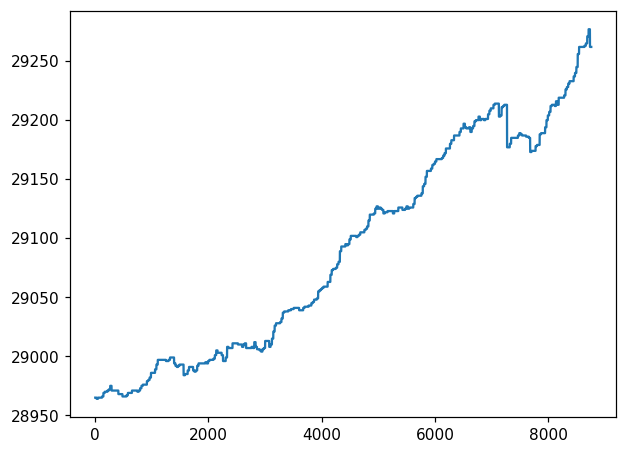

In [623]:
df_main['turbines_in_operation'].plot()

<Axes: >

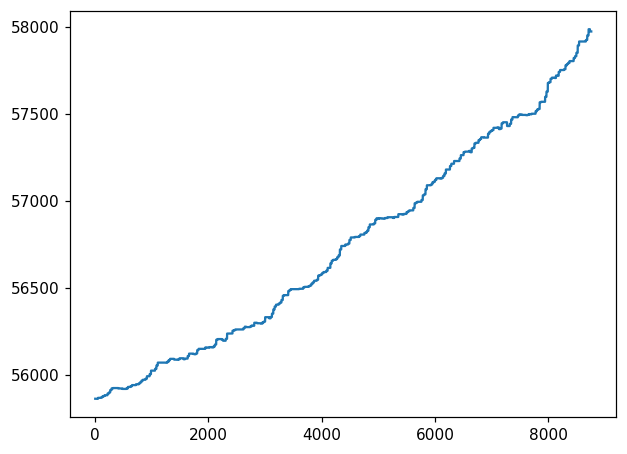

In [627]:
df_main['total_nominal_capacity_operational_turbines_mwh'].plot()

-----

## Test merging SMARD data onto `df` on key datetime

##### Generated data; the response variable `y`

In [653]:
# keep the datetime_cet column for reference
df_main = df_main.merge(df_smard_generated, left_on='datetime_utc', right_on='datetime_cet', how='left')

##### The day-ahead price data

In [660]:
# Figure out how to handle the overlapping cet columns? 
# -> only add suffix to overlapping columns in right df being merged
df_main = df_main.merge(df_smard_market_price, left_on='datetime_utc', right_on='datetime_cet', how='left', suffixes=(None, '_remove'))

In [667]:
# filter using regex; $ binds the expression to end of a string
df_main.drop(df_main.filter(regex='_remove$').columns, axis=1, inplace=True)

In [668]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column                                           Non-Null Count  Dtype              
---  ------                                           --------------  -----              
 0   datetime_utc                                     8760 non-null   datetime64[ns, UTC]
 1   hour                                             8760 non-null   int32              
 2   day_of_week                                      8760 non-null   int32              
 3   day_of_month                                     8760 non-null   int32              
 4   month_number                                     8760 non-null   int32              
 5   meteorological_season                            8760 non-null   object             
 6   turbines_in_operation                            8760 non-null   int64              
 7   total_nominal_capacity_operational_turbines_mwh  8760 non-null   float64      